## Predict which Tweets are about real disasters and which ones are not

In [2]:
# importing general packages
import numpy as np
import pandas as pd

# importing packages for text pre-porcessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup # package used for web scrapping to remove the HTML tags from the text ( not needed here)
import re # A package dealing with regular experession to remove punctuation and numbers
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

# importing packages for vectorization of text data
from sklearn.feature_extraction.text import CountVectorizer # bag of words vectorization
from sklearn.feature_extraction.text import TfidfVectorizer # Tf - idf vectorization
from sklearn.preprocessing import LabelEncoder

#importing packages for model-building
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,StratifiedKFold,LeaveOneOut
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt

# importing packages for sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#hiding all warnings
import warnings
warnings.filterwarnings('ignore')

import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### 1. Importing text data

In [3]:
# Importing data
data = pd.read_csv("/content/train.csv")
# data.set_index('id',inplace = True) # making the tweet id as index 
validation_data = pd.read_csv("/content/test.csv")
# validation_data.set_index('id',inplace = True) # making the tweet id as index

#adding the keyword to the text in the beggining to increase the weightage of the keyword in the tweet
for i in range(len(data)):
    if not pd.isna(data.iat[i,1]):
        data.iat[i,3] = str(data.iat[i,1])+ " " + data.iat[i,3]

for i in range(len(validation_data)):
    if not pd.isna(validation_data.iat[i,1]):
        validation_data.iat[i,3] = str(validation_data.iat[i,1])+ " " + validation_data.iat[i,3]

In [4]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### 2. Data Cleaning and preprocessing

In [5]:
# Removing irrelevant columns
data = data.drop(['keyword','location'], axis = 1)
validation_data = validation_data.drop(['keyword','location'], axis = 1) # data for model validation and submission
data

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [6]:
validation_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
# Performing named entity recognition and removing elements irrelvant categories from the text
# COnsidering following entity tags as irrelavant - ['LAW', 'ORDINAL', 'CARDINAL', 'LANGUAGE','TIME', 'MONEY', 'NORP']
def entity_removal(text,non_rel_cat=['LAW', 'ORDINAL','CARDINAL' 'LANGUAGE','TIME', 'MONEY', 'NORP']):
  """
  This function will tag entities into categories and remove entities with tags mentioned in the input arguments.
  As default value we consider following tags as irrelvant for this classification scenario - ['LAW', 'ORDINAL', 'CARDINAL', 'LANGUAGE','TIME', 'MONEY', 'NORP']
  """
  matcher = Matcher(nlp.vocab)
  named_entity_removal = []
  doc = nlp(text)
  for ent in doc.ents:
      if ent.label_ in non_rel_cat:
        named_entity_removal.append(ent.text)
  named_entity_removal = set(named_entity_removal)
  return named_entity_removal

In [8]:
raw_text = ''
for ele in data['text']:
  raw_text = raw_text + ele + ''
set_total = entity_removal(raw_text)

In [9]:
# function to clean data

# initializing stemming algorithm
ps = PorterStemmer() # porter stemmer
ss = SnowballStemmer('english') # snowball stemmer
# initializing lemmatizing algorithm
wnl = WordNetLemmatizer() # lemmatization
def text_clean_preprocess(raw_text : str):
    """
    This function will clean the data and perform certain preprocessing step of stemming/lemmatizing the words in 
    the tweet. Finally the function will remove stopwords and will only consider with words with a character length
    ranging from 2 to 10
    
    """
    vowel = ['a','e','i','o','u']
    text = BeautifulSoup(raw_text) # using the BeautifulSoup library to scrape the HTML tags from the text
    text = re.sub("[^a-zA-Z]"," ",text.get_text()) # removing all the punctions except the expressions ":)" and ":("
    text = text.lower() # converting all words to lowercase
    text = text.strip() # striping leading and trailing white spaces
    words = text.split()
    meaningful_words = [wnl.lemmatize(w) for w in words if w not in stopwords.words("english") and 2< len(w)<=15 and w[:4] != "http"]
    meaningful_words = [w for w in meaningful_words if w not in set_total]
    # meaningful_words = [ss.stem(w) for w in meaningful_words]
    return " ".join(meaningful_words)  
    

In [10]:
clean_tweets = [] # list to store all the cleaned tweets from the training data
clean_tweets_validation = [] # list to store all the cleaned tweets from validation data
for tweet in data['text']:
    clean_tweet = text_clean_preprocess(tweet)   
    clean_tweets.append(clean_tweet)
for tweet in validation_data['text']:
    clean_tweet = text_clean_preprocess(tweet)
    clean_tweets_validation.append(clean_tweet)

### Using Word2Vec to identify words associataed with disasters and non disastrous events

In [11]:
# d= pd.read_csv("/content/train.csv")
# disaster_words = list(set(d['keyword']))
# # disaster_words = disaster_words[1:]
# tweet_data  = clean_tweets
# sentences = []
# for ele in tweet_data:
#     sentences.append(ele.split())

# validation_sentences = []
# for ele in clean_tweets_validation:
#     validation_sentences.append(ele.split())

In [12]:
# from gensim.models.word2vec import Word2Vec
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
#     level=logging.INFO)

# # Set values for various parameters
# num_features = 1000    # Word vector dimensionality                      
# min_word_count = 100   # Minimum word count                        
# num_workers = 4       # Number of threads to run in parallel
# context = 50          # Context window size                                                                                    
# downsampling = 1e-3   # Downsample setting for frequent words

In [13]:
# model = Word2Vec(sentences, workers=num_workers, \
#              vector_size=num_features, min_count = min_word_count, \
#              window = context, sample = downsampling,sg=1)


# # If you don't plan to train the model any further, calling 
# # init_sims will make the model much more memory-efficient.
# model.init_sims(replace=True)

# # It can be helpful to create a meaningful model name and 
# # save the model for later use. You can load it later using Word2Vec.load()
# model_name = "300features_40minwords_10context"
# model.save(model_name)


In [14]:
# l = []
# mod_vocab = model.wv.index_to_key # vocabulary captured by the word2veec algorithm
# mod_vocab = sorted(set(mod_vocab))
# d= pd.read_csv("data/train.csv")
# disaster_words = list(set(d['keyword']))
# for ele in disaster_words[1:]:
#     if ele in mod_vocab:
#         #print(model.wv.most_similar(str(ele), topn = 5000))
#         disaster_words+=[ele[0] for ele in model.wv.most_similar(str(ele), topn = 5000)]
# disaster_vocab = list(set(disaster_words))

In [15]:
# Presenting the clean data in a dataframe
clean_data = pd.DataFrame(list(zip(data['id'],clean_tweets,data['target'])),columns = ['id','text','target'])
clean_data_validation = pd.DataFrame(list(zip(validation_data['id'],clean_tweets_validation)),columns = ['id','text'])
clean_data

,id,text,target
0,1,deed reason earthquake may allah forgive,1
1,4,forest fire near ronge sask canada,1
2,5,resident asked shelter place notified officer ...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby...,1
7609,10870,aria ahrary thetawniest control wild fire cali...,1
7610,10871,utc volcano hawaii zdtoyd ebj,1
7611,10872,police investigating bike collided car little ...,1


In [16]:
clean_data_validation

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different city stay safe ever...
2,3,forest fire spot pond goose fleeing across str...
3,9,apocalypse lighting spokane wildfire
4,11,typhoon soudelor kill china taiwan
...,...,...
3258,10861,earthquake safety los angeles safety fastener ...
3259,10865,storm worse last city others hardest hit yard ...
3260,10868,green line derailment chicago utbxlcbiuy
3261,10874,meg issue hazardous weather outlook hwo rbqjhn


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 3. Using Bag of Words/TF IDF to convert the text data into vectors

In [18]:
# Initializing countvectorizer
corpus = clean_tweets
cv = CountVectorizer(max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)

#converting text from the train data and test data into vectors
# train_vector = cv.fit_transform(corpus)
data_vector = vectorizer.fit_transform(corpus)
print(data_vector.toarray())

# Performing vectorization on validation data
validation_vector = vectorizer.transform(clean_tweets_validation)
print(validation_vector.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 4. Training the model

In [19]:
# Generating the training dataframe
train_df = pd.DataFrame(data_vector.toarray(), columns = vectorizer.get_feature_names())
train_df.head()

# Generating validation dataframe
validation_df = pd.DataFrame(validation_vector.toarray(), columns = vectorizer.get_feature_names())
validation_df

# Splitting the data for training and testing
X_train, X_test,Y_train, Y_test = train_test_split(train_df,clean_data['target'], test_size=0.33, random_state=42)
# X = train_df
# Y = clean_data['target']

In [20]:
a = pd.concat([train_df, data['target'],data['id']], axis=1)
b = a[a["storm"]>0.5]
b[['storm','target','id']]
train_df.to_csv("vector.csv")
train_df

,aba,abandon,abandoned,abbott,abbswinston,abc,abcnews,abe,abia,ability,ablaze,able,abomination,abortion,absolutely,abstorm,abuse,abused,acc,access,accident,accidentally,accionempresa,according,account,accused,accuses,acid,acre,across,act,acted,acting,action,activated,activates,active,activity,actor,actress,...,yellow,yemen,yep,yes,yesterday,yet,yev,ymcglaun,yobe,yonews,york,yorker,yougov,young,younger,youngheroesid,youth,youtube,ypres,yr,yug,yugvani,yup,yyc,yycstorm,zabadani,zak,zarry,zayn,zaynmalik,zdtoyd,zero,zevakjapcz,zimbabwe,zionism,zionist,zombie,zone,zouma,zujwuiomb
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.593762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Function to create a confusion matrix to understand the metrics associated with a classification model
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    source:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 5. Using MultinomialNB Algorithm to train the model

In [22]:
classifier=MultinomialNB()
classifier.fit(X_train,Y_train)
# stratifiedkf=StratifiedKFold(n_splits=5)
# loo=LeaveOneOut()
# scores_mnb = cross_val_score(classifier, X, Y, cv=loo)
# print(scores_mnb)

MultinomialNB()

### 6. Using the trained model to predict the outcome and evaluating the metrics to check the model performance

accuracy:   0.793
Confusion matrix, without normalization


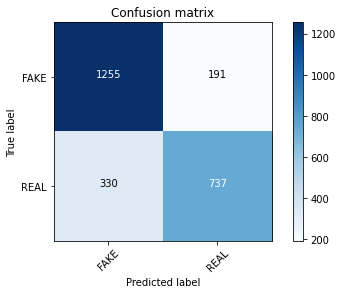

In [23]:
pred = classifier.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [24]:
# Tuning the multinomial NB model to different values of hyper parameter alpha
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,Y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(Y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.7540787902904894
Alpha: 0.1, Score : 0.7902904894548348
Alpha: 0.2, Score : 0.7946677278153601
Alpha: 0.30000000000000004, Score : 0.7954635893354556
Alpha: 0.4, Score : 0.7954635893354556
Alpha: 0.5, Score : 0.7950656585754079
Alpha: 0.6000000000000001, Score : 0.7950656585754079
Alpha: 0.7000000000000001, Score : 0.7934739355352168
Alpha: 0.8, Score : 0.7930760047751692
Alpha: 0.9, Score : 0.7950656585754079


In [25]:
val = classifier.predict(validation_df)
val

array([1, 1, 1, ..., 1, 1, 1])

[0.7372549  0.77156863 0.74803922 0.70490196 0.74705882]
[0 0 1 ... 1 0 0]
accuracy:   0.755
Confusion matrix, without normalization


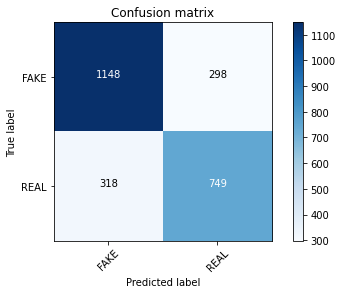

In [26]:
# Using ridge regression to fit the model
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
clf_ridge = linear_model.RidgeClassifier(alpha = 0.1)
scores_ridge = cross_val_score(clf_ridge, X_train, Y_train, cv=5)
print(scores_ridge)
clf_ridge.fit(X_train, Y_train)
pred = clf_ridge.predict(X_test)
print(pred)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.751
Confusion matrix, without normalization


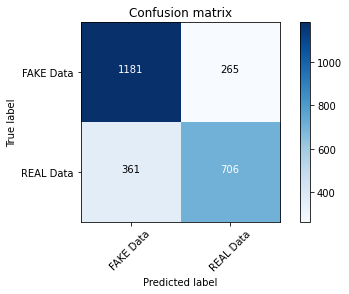

In [27]:
# Using PassiveAggressiveClassifier to fit the model
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)
linear_clf.fit(X_train, Y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

accuracy:   0.751
Confusion matrix, without normalization


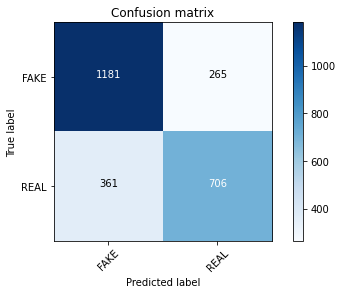

In [28]:
# Using random forest classifier to fit the model
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier module
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(X_train,Y_train)
forest_result = forest.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [29]:
validation_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [30]:
val = pd.DataFrame(val, columns = ['target'])
val

,target
0,1
1,1
2,1
3,1
4,1
...,...
3258,1
3259,0
3260,1
3261,1


In [31]:
index = validation_data[['id']]
index

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [32]:
submission = pd.concat([index,val],axis = 1)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [33]:
submission.to_csv('submission.csv', index = False)

accuracy:   0.776
Confusion matrix, without normalization


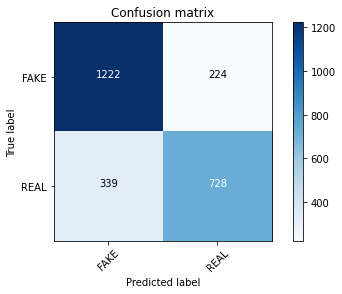

In [34]:
# Using random forest classifier to fit the model
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier module
forest = RandomForestClassifier(n_estimators = 500)
forest = forest.fit(X_train,Y_train)
forest_result = forest.predict(X_test)
score = metrics.accuracy_score(Y_test, forest_result)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(Y_test, forest_result)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [35]:
# https://imerit.net/blog/top-25-twitter-datasets-for-natural-language-processing-and-machine-learning-all-pbm/
# Training a word2vec model